# Anomaly Detection Evaluation

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import mixture
import json
import sys
import os
sys.path.insert(0, '..')
from database import mongo_client
from anomaly_detection import evaluation
from anomaly_detection import preprocessing as ad_pp
from anomaly_detection import GMM
from anomaly_detection import PCA
from anomaly_detection import results
%matplotlib inline
matplotlib.style.use('ggplot')
from IPython.display import display
# auto-load changes in imported modules
%load_ext autoreload
%autoreload 2

In [2]:
filename = "all_features_(B1)_2017-04-09" #30min, B1
filename = os.path.join('..', 'CSV', filename + ".csv")
B1_30 = pd.read_csv(filename, index_col=0)
B1_30.index = pd.to_datetime(B1_30.index)
B1_30_s = ad_pp.scale_robust(B1_30)

filename = "all_features_(B2)_2017-04-09" #30min, B2
filename = os.path.join('..', 'CSV', filename + ".csv")
B2_30 = pd.read_csv(filename, index_col=0)
B2_30.index = pd.to_datetime(B2_30.index)
B2_30_s = ad_pp.scale_robust(B2_30)

In [3]:
client = mongo_client.CERNMongoClient()
start_date = '2016-04-16 00:00:00.000000'
end_date = '2016-09-14 00:00:00.000000'
labeled = client.query_tagged_anomalies(start_date, end_date)

Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged


## Model Selection

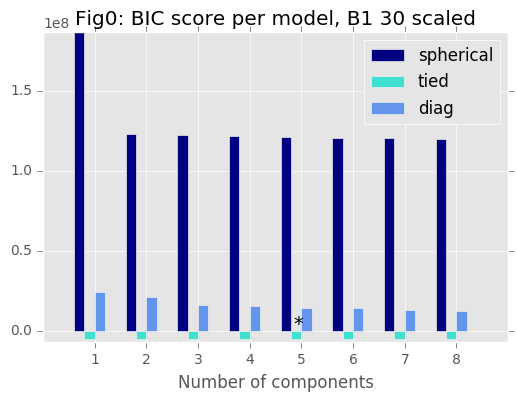

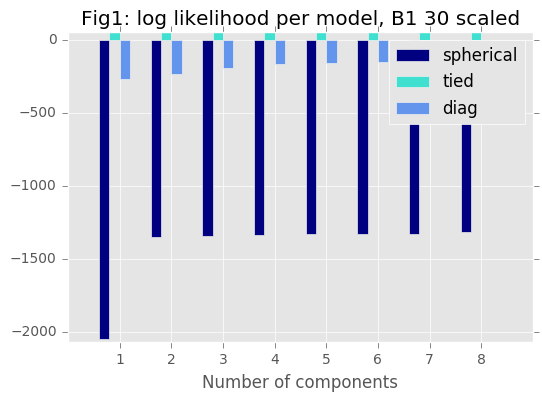

In [10]:
GMM.component_selection(B1_30_s, 'Fig0: BIC score per model, B1 30 scaled', cv_types=['spherical', 'tied', 'diag'])
GMM.log_likelihood_selection(B1_30_s, 'Fig1: log likelihood per model, B1 30 scaled', cv_types=['spherical', 'tied', 'diag'])

## Evaluation

In [4]:
clf_B1 = mixture.GaussianMixture(n_components=5, covariance_type='tied')
clf_B1.fit(B1_30_s)
clf_B2 = mixture.GaussianMixture(n_components=5, covariance_type='tied')
clf_B2.fit(B2_30_s)

GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
        means_init=None, n_components=5, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [5]:
B1_w_probs = GMM.add_sorted_anomaly_probs(clf_B1, B1_30_s)
B2_w_probs = GMM.add_sorted_anomaly_probs(clf_B2, B2_30_s)

Function adds an extra column to the feature df with the log probs. The dataframe is also sorted with the first row having the lowest log probability. 

### Segmentation

In [6]:
anomaly_sizes = [200, 250, 500, 750, 1000]
segmenter = evaluation.AnomalySegmenter()
segments_B1 = list(segmenter.segments_generator(B1_w_probs, anomaly_sizes))
segments_B2 = list(segmenter.segments_generator(B2_w_probs, anomaly_sizes))

New segmentation algorithm:
- start with N1 most anomalous points
- create segments
- add N2 more anomalous points
- if point IN segmentation: add it, do NOT expand existing segmentations  
  else: create new segmentation if clear from existing cluster (eg X hour boundary)
- repeat

Current settings:
- max distance to segment: 12 hours
- metric for segment distance: "mean"
- boundary around existing segments: 12 hours
- sizes to segment: anomaly_sizes

In [7]:
tables = [evaluation.compare_segmented_with_labeled(segments_B1[i], segments_B2[i], labeled) for i in range(len(segments_B1))]
for table in tables:
    display(table)

nb_detected_B1  nb_segments_B1  nb_detected_B2  \
timestamps                                                            
2016-05-30 14:00:00               3               1               1   
2016-06-05 17:18:00               0               0               1   
2016-06-18 19:59:00               0               0               0   
2016-06-19 13:14:00               2               1               1   
2016-06-30 21:23:00               7               1               5   
2016-07-14 09:23:00               0               0               0   
2016-07-24 22:19:48               0               0               0   
2016-07-31 16:00:00               0               0               0   
2016-08-02 17:28:00              65               1               0   
2016-08-02 17:50:00              65               1               0   
2016-08-03 08:05:00               0               0               2   
2016-08-04 14:03:41               0               0               0   
2016-08-21 20:00:00               0               0              17   
2016-08-22 21:30:30               0               0               0   
2016-08-23 06:53:47               0               0               0   
2016-09-02 17:43:00               0               0               0   

                     nb_segments_B2 installation  
timestamps                                        
2016-05-30 14:00:00               1         MKI8  
2016-06-05 17:18:00               1         MKI8  
2016-06-18 19:59:00               0         MKI8  
2016-06-19 13:14:00               1         MKI2  
2016-06-30 21:23:00               1         MKI2  
2016-07-14 09:23:00               0         MKI8  
2016-07-24 22:19:48               0         MKI2  
2016-07-31 16:00:00               0         MKI2  
2016-08-02 17:28:00               0         MKI2  
2016-08-02 17:50:00               0         MKI2  
2016-08-03 08:05:00               1         MKI2  
2016-08-04 14:03:41               0         MKI2  
2016-08-21 20:00:00               1         MKI8  
2016-08-22 21:30:30               0         MKI8  
2016-08-23 06:53:47               0         MKI2  
2016-09-02 17:43:00               0         MKI8

nb_detected_B1  nb_segments_B1  nb_detected_B2  \
timestamps                                                            
2016-05-30 14:00:00               3               1               1   
2016-06-05 17:18:00               0               0               1   
2016-06-18 19:59:00               0               0               0   
2016-06-19 13:14:00               5               1               1   
2016-06-30 21:23:00               9               1              27   
2016-07-14 09:23:00               0               0               0   
2016-07-24 22:19:48               0               0               0   
2016-07-31 16:00:00               0               0               0   
2016-08-02 17:28:00              74               1               0   
2016-08-02 17:50:00              74               1               0   
2016-08-03 08:05:00               0               0               2   
2016-08-04 14:03:41               0               0               0   
2016-08-21 20:00:00               0               0              25   
2016-08-22 21:30:30               0               0               0   
2016-08-23 06:53:47               0               0               0   
2016-09-02 17:43:00               0               0               0   

                     nb_segments_B2 installation  
timestamps                                        
2016-05-30 14:00:00               1         MKI8  
2016-06-05 17:18:00               1         MKI8  
2016-06-18 19:59:00               0         MKI8  
2016-06-19 13:14:00               1         MKI2  
2016-06-30 21:23:00               1         MKI2  
2016-07-14 09:23:00               0         MKI8  
2016-07-24 22:19:48               0         MKI2  
2016-07-31 16:00:00               0         MKI2  
2016-08-02 17:28:00               0         MKI2  
2016-08-02 17:50:00               0         MKI2  
2016-08-03 08:05:00               1         MKI2  
2016-08-04 14:03:41               0         MKI2  
2016-08-21 20:00:00               1         MKI8  
2016-08-22 21:30:30               0         MKI8  
2016-08-23 06:53:47               0         MKI2  
2016-09-02 17:43:00               0         MKI8

nb_detected_B1  nb_segments_B1  nb_detected_B2  \
timestamps                                                            
2016-05-30 14:00:00               3               1               1   
2016-06-05 17:18:00               1               1               1   
2016-06-18 19:59:00               0               0               0   
2016-06-19 13:14:00              25               1               1   
2016-06-30 21:23:00              38               1              77   
2016-07-14 09:23:00               0               0               0   
2016-07-24 22:19:48               0               0               0   
2016-07-31 16:00:00               0               0               0   
2016-08-02 17:28:00             106               1               1   
2016-08-02 17:50:00             106               1               1   
2016-08-03 08:05:00               0               0               2   
2016-08-04 14:03:41               1               1               1   
2016-08-21 20:00:00               0               0              58   
2016-08-22 21:30:30               0               0               0   
2016-08-23 06:53:47               0               0               0   
2016-09-02 17:43:00               0               0               0   

                     nb_segments_B2 installation  
timestamps                                        
2016-05-30 14:00:00               1         MKI8  
2016-06-05 17:18:00               1         MKI8  
2016-06-18 19:59:00               0         MKI8  
2016-06-19 13:14:00               1         MKI2  
2016-06-30 21:23:00               1         MKI2  
2016-07-14 09:23:00               0         MKI8  
2016-07-24 22:19:48               0         MKI2  
2016-07-31 16:00:00               0         MKI2  
2016-08-02 17:28:00               1         MKI2  
2016-08-02 17:50:00               1         MKI2  
2016-08-03 08:05:00               1         MKI2  
2016-08-04 14:03:41               1         MKI2  
2016-08-21 20:00:00               1         MKI8  
2016-08-22 21:30:30               0         MKI8  
2016-08-23 06:53:47               0         MKI2  
2016-09-02 17:43:00               0         MKI8

nb_detected_B1  nb_segments_B1  nb_detected_B2  \
timestamps                                                            
2016-05-30 14:00:00               3               1               1   
2016-06-05 17:18:00               1               1               1   
2016-06-18 19:59:00               0               0               0   
2016-06-19 13:14:00              40               1               1   
2016-06-30 21:23:00              69               1              92   
2016-07-14 09:23:00               2               1               0   
2016-07-24 22:19:48               1               1               1   
2016-07-31 16:00:00               0               0               1   
2016-08-02 17:28:00             144               1               1   
2016-08-02 17:50:00             144               1               1   
2016-08-03 08:05:00               0               0               2   
2016-08-04 14:03:41               1               1               1   
2016-08-21 20:00:00               2               1              66   
2016-08-22 21:30:30               0               0               0   
2016-08-23 06:53:47               0               0               0   
2016-09-02 17:43:00               0               0               0   

                     nb_segments_B2 installation  
timestamps                                        
2016-05-30 14:00:00               1         MKI8  
2016-06-05 17:18:00               1         MKI8  
2016-06-18 19:59:00               0         MKI8  
2016-06-19 13:14:00               1         MKI2  
2016-06-30 21:23:00               1         MKI2  
2016-07-14 09:23:00               0         MKI8  
2016-07-24 22:19:48               1         MKI2  
2016-07-31 16:00:00               1         MKI2  
2016-08-02 17:28:00               1         MKI2  
2016-08-02 17:50:00               1         MKI2  
2016-08-03 08:05:00               1         MKI2  
2016-08-04 14:03:41               1         MKI2  
2016-08-21 20:00:00               1         MKI8  
2016-08-22 21:30:30               0         MKI8  
2016-08-23 06:53:47               0         MKI2  
2016-09-02 17:43:00               0         MKI8

nb_detected_B1  nb_segments_B1  nb_detected_B2  \
timestamps                                                            
2016-05-30 14:00:00               3               1               1   
2016-06-05 17:18:00               1               1               1   
2016-06-18 19:59:00               0               0               1   
2016-06-19 13:14:00              49               1               1   
2016-06-30 21:23:00              87               1             105   
2016-07-14 09:23:00               2               1               0   
2016-07-24 22:19:48               1               1               1   
2016-07-31 16:00:00               0               0               1   
2016-08-02 17:28:00             182               1               1   
2016-08-02 17:50:00             182               1               1   
2016-08-03 08:05:00               0               0               2   
2016-08-04 14:03:41               1               1               1   
2016-08-21 20:00:00               2               1              83   
2016-08-22 21:30:30               0               0               0   
2016-08-23 06:53:47               0               0               0   
2016-09-02 17:43:00               0               0               0   

                     nb_segments_B2 installation  
timestamps                                        
2016-05-30 14:00:00               1         MKI8  
2016-06-05 17:18:00               1         MKI8  
2016-06-18 19:59:00               1         MKI8  
2016-06-19 13:14:00               1         MKI2  
2016-06-30 21:23:00               1         MKI2  
2016-07-14 09:23:00               0         MKI8  
2016-07-24 22:19:48               1         MKI2  
2016-07-31 16:00:00               1         MKI2  
2016-08-02 17:28:00               1         MKI2  
2016-08-02 17:50:00               1         MKI2  
2016-08-03 08:05:00               1         MKI2  
2016-08-04 14:03:41               1         MKI2  
2016-08-21 20:00:00               1         MKI8  
2016-08-22 21:30:30               0         MKI8  
2016-08-23 06:53:47               0         MKI2  
2016-09-02 17:43:00               0         MKI8

### Visualisation

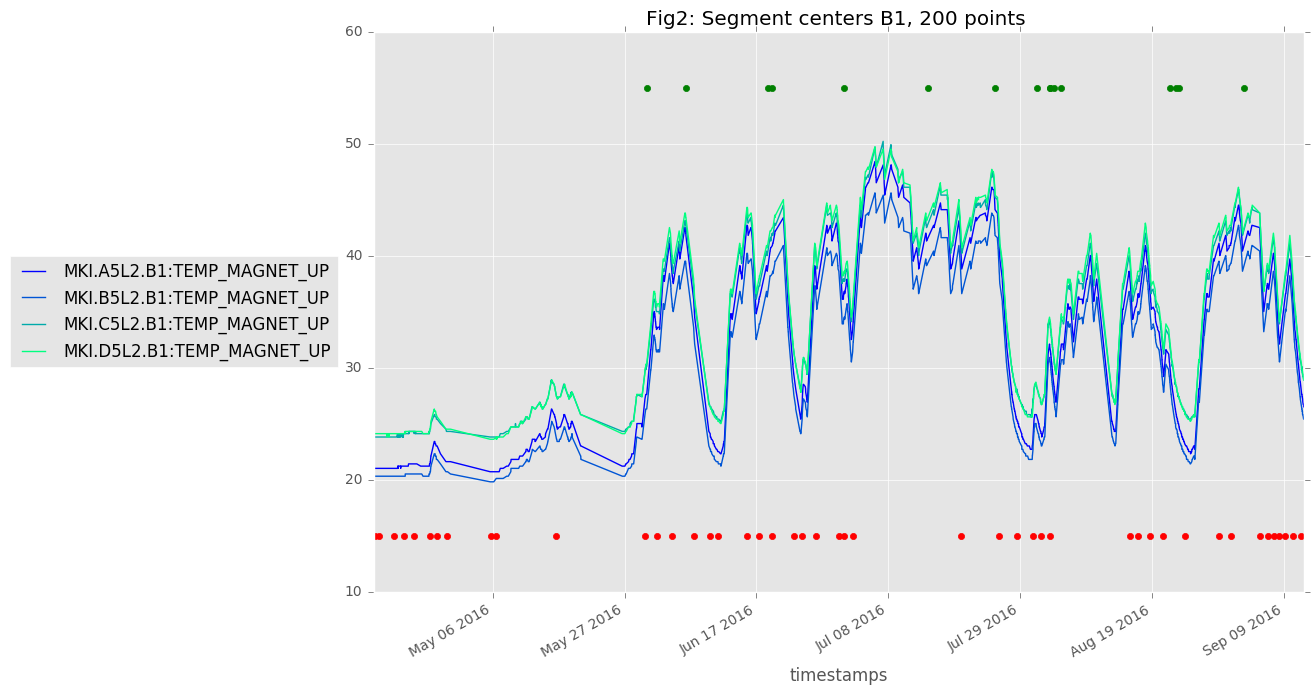

In [11]:
evaluation.plot_segments_series(B1_30, "TEMP_MAGNET_UP", segments_B1[0], labeled, 'Fig2: Segment centers B1, 200 points ')

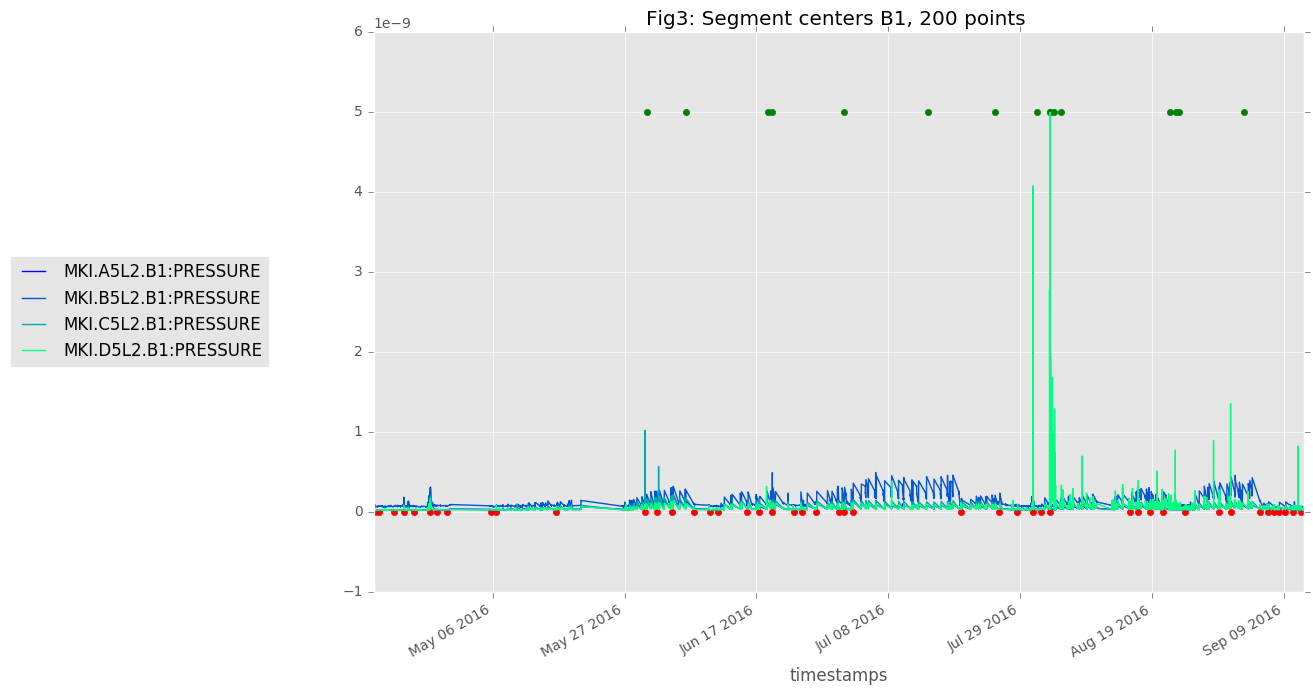

In [12]:
evaluation.plot_segments_series(B1_30, "PRESSURE", segments_B1[0], labeled, 'Fig3: Segment centers B1, 200 points ')